In [1]:
!pip install pandas


In [2]:
!pip install openpyxl

In [3]:
import pandas as pd

# Load Excel file
df = pd.read_excel("gym_recommendation.xlsx")  # Change filename if needed

# Display basic info
print(df.info())  # Check data types and missing values
print(df.head())  # View first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14589 entries, 0 to 14588
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              14589 non-null  int64  
 1   Sex             14589 non-null  object 
 2   Age             14589 non-null  int64  
 3   Height          14589 non-null  float64
 4   Weight          14589 non-null  float64
 5   Hypertension    14589 non-null  object 
 6   Diabetes        14589 non-null  object 
 7   BMI             14589 non-null  float64
 8   Level           14589 non-null  object 
 9   Fitness Goal    14589 non-null  object 
 10  Fitness Type    14589 non-null  object 
 11  Exercises       14589 non-null  object 
 12  Equipment       14589 non-null  object 
 13  Diet            14589 non-null  object 
 14  Recommendation  14589 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 1.7+ MB
None
   ID   Sex  Age  Height  Weight Hypertension Diabetes    

In [4]:
# Drop rows with too many missing values
df = df.dropna(thresh=len(df.columns) * 0.5)

# Fill missing numerical values with median
num_cols = ["Age", "Height", "Weight", "BMI"]
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill missing categorical values with mode
cat_cols = ["Sex", "Hypertension", "Diabetes", "Level", "Fitness Goal", "Fitness Type"]
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


In [5]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
categorical_cols = ["Sex", "Hypertension", "Diabetes", "Level"]
for col in categorical_cols:
    df[col] = label_enc.fit_transform(df[col])


In [6]:
# Create Fitness Risk Score
df["Fitness Risk Score"] = df["BMI"] * (df["Hypertension"] + df["Diabetes"] + 1)

# Normalize Fitness Risk Score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df["Fitness Risk Score"] = scaler.fit_transform(df[["Fitness Risk Score"]])


In [7]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical columns
scale_cols = ["Age", "Height", "Weight", "BMI"]
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])


In [8]:
# Save cleaned dataset as Excel file
df.to_excel("processed_fitness_data.xlsx", index=False)
print("Preprocessing complete! Data saved as Excel file.")


Preprocessing complete! Data saved as Excel file.


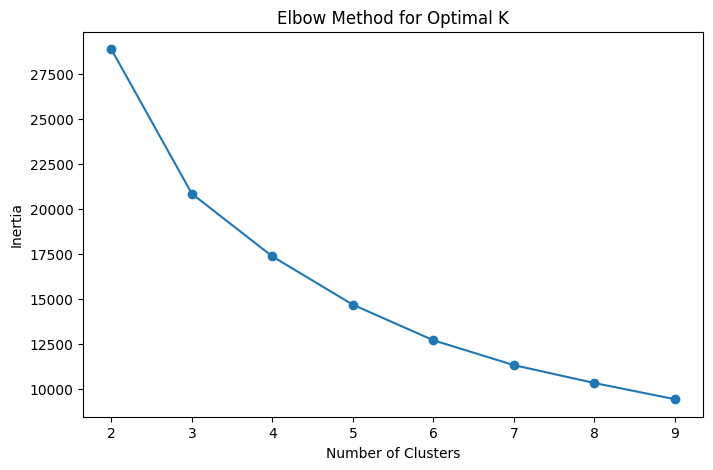

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load Preprocessed Data
df = pd.read_excel("processed_fitness_data.xlsx")  

# Features for Clustering
features = ["Age", "BMI", "Fitness Risk Score"]
X = df[features]

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Finding optimal K 
inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

In [10]:
# Choose the best K from the Elbow Curve (Example: 4)
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["community_cluster"] = kmeans.fit_predict(X_scaled)

# Save clustered dataset
df.to_excel("user_clusters.xlsx", index=False)
print("User clustering complete! Users are assigned to fitness communities.")


User clustering complete! Users are assigned to fitness communities.


In [11]:
!pip install xgboost

In [12]:
import xgboost as xgb
print(xgb.__version__)


3.0.0


In [13]:
print(df.columns)


Index(['ID', 'Sex', 'Age', 'Height', 'Weight', 'Hypertension', 'Diabetes',
       'BMI', 'Level', 'Fitness Goal', 'Fitness Type', 'Exercises',
       'Equipment', 'Diet', 'Recommendation', 'Fitness Risk Score',
       'community_cluster'],
      dtype='object')


In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Features & Target
X = df[["Age", "BMI", "Fitness Risk Score"]]
y = df["community_cluster"]  # Target: Fitness Community Label

# Split into Training & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=4, eval_metric="mlogloss", use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Classification Report
print(classification_report(y_test, y_pred))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:56:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1014
           1       1.00      0.99      1.00       649
           2       1.00      1.00      1.00       776
           3       0.99      1.00      0.99       479

    accuracy                           1.00      2918
   macro avg       1.00      1.00      1.00      2918
weighted avg       1.00      1.00      1.00      2918



In [15]:
train_accuracy = xgb_model.score(X_train, y_train)
test_accuracy = xgb_model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")


Training Accuracy: 1.00
Testing Accuracy: 1.00


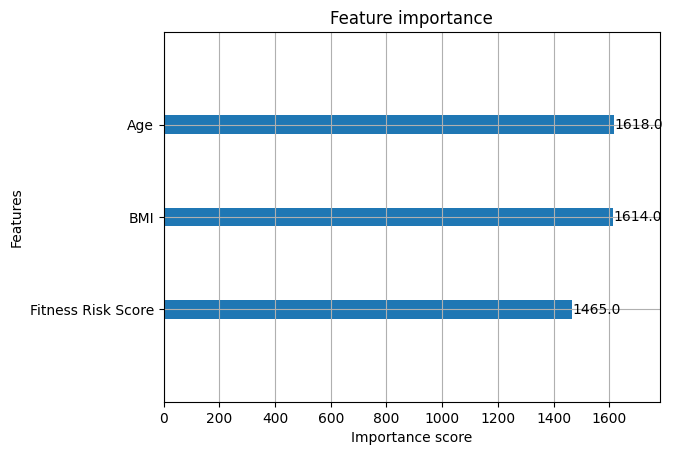

In [16]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance
xgb.plot_importance(xgb_model)
plt.show()


In [17]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=4,
    eval_metric="mlogloss",
    use_label_encoder=False,
    max_depth=6,       # Reduce tree depth (default is 6-10)
    learning_rate=0.1,  # Reduce learning rate (default is 0.3)
    n_estimators=100,   # Reduce number of trees (default is 100+)
    reg_lambda=10,      # L2 Regularization
    reg_alpha=5,        # L1 Regularization
)

xgb_model.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:56:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=4, ...)

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score


# Features & Target
X = df[["Age", "BMI", "Fitness Risk Score"]]
y = df["community_cluster"]  # Target: Fitness Community Label

# Split into Training & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=4,
    eval_metric="mlogloss",
    use_label_encoder=False,
    max_depth=6,       # Reduce tree depth (default is 6-10)
    learning_rate=0.1,  # Reduce learning rate (default is 0.3)
    n_estimators=100,   # Reduce number of trees (default is 100+)
    reg_lambda=10,      # L2 Regularization
    reg_alpha=5,        # L1 Regularization
)

xgb_model.fit(X_train, y_train)


# Predict & Evaluate
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Classification Report
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(xgb_model, X, y, cv=5)
print(f"Cross-validation Accuracy: {cv_scores.mean():.2f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1594
           1       0.99      0.99      0.99       965
           2       1.00      1.00      1.00      1118
           3       0.99      0.99      0.99       700

    accuracy                           1.00      4377
   macro avg       1.00      1.00      1.00      4377
weighted avg       1.00      1.00      1.00      4377



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:56:12] WARN

Cross-validation Accuracy: 0.99


In [19]:
df.describe()  # See if features have high variance
df["community_cluster"].value_counts()  # Check class distribution


community_cluster
0    5350
2    3782
1    3184
3    2273
Name: count, dtype: int64

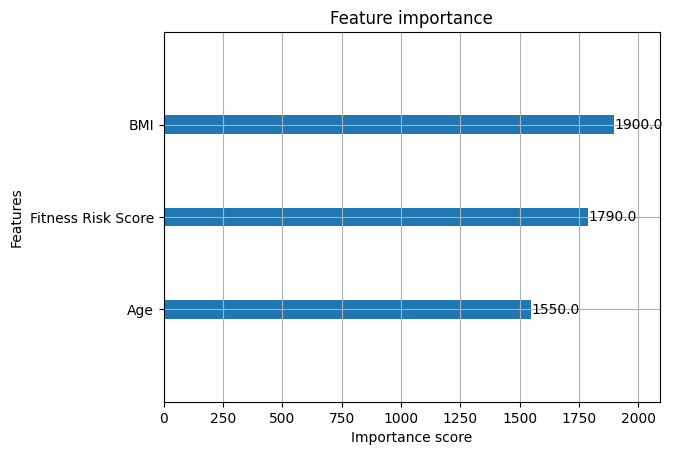

In [20]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model)
plt.show()


In [21]:
import pandas as pd

# Load your processed profiling dataset
df = pd.read_excel("processed_fitness_data.xlsx") 

print(df.head())
df.columns

   ID  Sex      Age    Height   Weight  Hypertension  Diabetes       BMI  \
0   1    1 -1.63391 -0.202298 -1.14858             0         0 -1.121606   
1   2    1 -1.63391 -0.202298 -1.14858             1         0 -1.121606   
2   3    1 -1.63391 -0.202298 -1.14858             0         1 -1.121606   
3   4    1 -1.63391 -0.202298 -1.14858             1         1 -1.121606   
4   5    1 -1.63391 -0.202298 -1.14858             0         0 -1.121606   

   Level Fitness Goal      Fitness Type  \
0      3  Weight Gain  Muscular Fitness   
1      3  Weight Gain  Muscular Fitness   
2      3  Weight Gain  Muscular Fitness   
3      3  Weight Gain  Muscular Fitness   
4      3  Weight Gain  Muscular Fitness   

                                           Exercises  \
0  Squats, deadlifts, bench presses, and overhead...   
1  Squats, deadlifts, bench presses, and overhead...   
2  Squats, yoga, deadlifts, bench presses, and ov...   
3  Squats, yoga, deadlifts, bench presses, and ov...   
4  S

Index(['ID', 'Sex', 'Age', 'Height', 'Weight', 'Hypertension', 'Diabetes',
       'BMI', 'Level', 'Fitness Goal', 'Fitness Type', 'Exercises',
       'Equipment', 'Diet', 'Recommendation', 'Fitness Risk Score'],
      dtype='object')

In [22]:
# Create input_text combining fitness type, fitness goal, and risk score
df["input_text"] = (
    "generate_post: User following " + df["Fitness Type"] +
    " program aiming for " + df["Fitness Goal"] +
    " with a fitness risk score of " + df["Fitness Risk Score"].astype(str)
)

# Create target_text dynamically based on fitness type
def generate_target_text(row):
    if "Cardio" in row["Fitness Type"]:
        return "Warm up with light jogging. Aim for 30 minutes of steady-state cardio today 🚴."
    elif "Strength" in row["Fitness Type"]:
        return "Hit those compound lifts today 💪. Focus on squats, deadlifts, and presses."
    elif "Yoga" in row["Fitness Type"]:
        return "Stretch out and relax with a calming 20-minute yoga session 🧘."
    elif "Rehabilitation" in row["Fitness Type"]:
        return "Prioritize light stretches and low-impact exercises like walking 🩺."
    else:
        return "Stay consistent with your fitness journey — your health matters!"

df["target_text"] = df.apply(generate_target_text, axis=1)

# Save input-output pairs to .xlsx
df[["input_text", "target_text"]].to_excel("fitness_content_generation_pairs.xlsx", index=False)

# Preview first few rows
print(df[["input_text", "target_text"]].head())


                                          input_text  \
0  generate_post: User following Muscular Fitness...   
1  generate_post: User following Muscular Fitness...   
2  generate_post: User following Muscular Fitness...   
3  generate_post: User following Muscular Fitness...   
4  generate_post: User following Muscular Fitness...   

                                         target_text  
0  Stay consistent with your fitness journey — yo...  
1  Stay consistent with your fitness journey — yo...  
2  Stay consistent with your fitness journey — yo...  
3  Stay consistent with your fitness journey — yo...  
4  Stay consistent with your fitness journey — yo...  


In [23]:
import pandas as pd

df = pd.read_excel("fitness_content_generation_pairs.xlsx")
df = df[["input_text", "target_text"]]
print(df.head())
df.columns

                                          input_text  \
0  generate_post: User following Muscular Fitness...   
1  generate_post: User following Muscular Fitness...   
2  generate_post: User following Muscular Fitness...   
3  generate_post: User following Muscular Fitness...   
4  generate_post: User following Muscular Fitness...   

                                         target_text  
0  Stay consistent with your fitness journey — yo...  
1  Stay consistent with your fitness journey — yo...  
2  Stay consistent with your fitness journey — yo...  
3  Stay consistent with your fitness journey — yo...  
4  Stay consistent with your fitness journey — yo...  


Index(['input_text', 'target_text'], dtype='object')

In [24]:
!pip install tf-keras
!pip install sentencepiece
!pip install transformers datasets accelerate
!pip install evaluate
!pip install nltk rouge_score


In [25]:
import pandas as pd

# Load your raw fitness dataset
df = pd.read_excel("processed_fitness_data.xlsx")

# Check data types
print(df.dtypes)

# ✅ Confirm that 'Fitness Goal' and 'Fitness Type' are text — no LabelEncoder involved now.

# Create input_text combining fitness type, fitness goal, and risk score
df["input_text"] = (
    "generate_summary: User targeting " + df["Fitness Goal"] +
    " via " + df["Fitness Type"] +
    " with a risk score of " + df["Fitness Risk Score"].astype(str)
)

# ✅ Create target_text by combining 'Exercises' and 'Recommendation'
df["target_text"] = (
    "Recommended Exercises: " + df["Exercises"] + 
    " | Trainer Recommendation: " + df["Recommendation"]
)

# Preview
print(df[["input_text", "target_text"]].head())

# Save input-output pairs to a new .xlsx file for model fine-tuning
df[["input_text", "target_text"]].to_excel("fitness_content_generation_pairs2.xlsx", index=False)

print("✅ Content generation pairs file created successfully!")


ID                      int64
Sex                     int64
Age                   float64
Height                float64
Weight                float64
Hypertension            int64
Diabetes                int64
BMI                   float64
Level                   int64
Fitness Goal           object
Fitness Type           object
Exercises              object
Equipment              object
Diet                   object
Recommendation         object
Fitness Risk Score    float64
dtype: object
                                          input_text  \
0  generate_summary: User targeting Weight Gain v...   
1  generate_summary: User targeting Weight Gain v...   
2  generate_summary: User targeting Weight Gain v...   
3  generate_summary: User targeting Weight Gain v...   
4  generate_summary: User targeting Weight Gain v...   

                                         target_text  
0  Recommended Exercises: Squats, deadlifts, benc...  
1  Recommended Exercises: Squats, deadlifts, benc...  
2  R

In [ ]:
import os
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
import evaluate

# Load new datasets
df_content = pd.read_excel("fitness_content_generation_pairs2.xlsx")
df_profile = pd.read_excel("processed_fitness_data.xlsx")

# Create 'community_type' by combining 'Fitness Goal' and 'Fitness Type' (both already text)
df_profile['community_type'] = df_profile['Fitness Goal'] + " | " + df_profile['Fitness Type']

# Assign a community type to each content sample randomly (since no direct mapping)
df_content['community_type'] = df_profile['community_type'].sample(n=len(df_content), replace=True, random_state=42).values

# 🔹 Sample 500 random records for quick fine-tuning (or use full set if small)
df_sampled_content = df_content.sample(n=500, random_state=42).reset_index(drop=True)

# Convert sampled DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df_sampled_content)

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Load ROUGE evaluation metric
rouge = evaluate.load("rouge")

# Preprocessing function (tokenization + add community context)
def preprocess_function(examples):
    inputs = tokenizer(
        [f"Community: {community} | {text}" for community, text in zip(examples['community_type'], examples['input_text'])],
        truncation=True, padding="max_length", max_length=256
    )
    targets = tokenizer(
        examples['target_text'],
        truncation=True, padding="max_length", max_length=128
    )
    inputs["labels"] = targets["input_ids"]
    return inputs

# Apply preprocessing to dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Compute ROUGE metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=5e-5,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    fp16=False,
    no_cuda=True  # CPU mode to avoid MPS precision issues (Mac)
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save model and tokenizer after training
model.save_pretrained("./results/fitness_t5_model_v2")
tokenizer.save_pretrained("./results/fitness_t5_model_v2")

print("✅ Fine-tuning complete and model saved.")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Map: 100%|██████████| 500/500 [00:00<00:00, 1329.77 examples/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/training_args.py:1595: FutureWarning: using `no_cuda` is deprecated and will be removed in versi